<a href="https://colab.research.google.com/github/PaulRobertH/wine-ml-portfolio/blob/main/Livex100_ML_Forecasting_Report5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


In [105]:
# Load the cleaned file you saved previously
df = pd.read_csv('/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv', index_col=0, parse_dates=True)


In [106]:
# Load cleaned dataset
df = pd.read_csv(
    '/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv',
    index_col=0,
    parse_dates=True
)

# Drop missing data just for safety
series = df['Liv-ex 100'].dropna()

# ✅ Filter out dates earlier than 2003
series = series[series.index >= '2004-01-01']

# Preview
series.tail()



,Liv-ex 100
2025-01-31,326.14
2025-02-28,323.51
2025-03-31,321.13
2025-04-30,315.70
2025-05-31,314.25


In [107]:
# Convert dates to ordinal numbers
X = series.index.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y = series.values


In [108]:
# Capstone kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=50, length_scale_bounds=(1e-2, 1e4))

# Gaussian Process model
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    normalize_y=True
)


In [109]:
# Fit the GP model to historical data
gp.fit(X, y)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=50),
                         n_restarts_optimizer=10, normalize_y=True)

In [110]:
# Create future dates
future_days = 365
last_date = series.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_days, freq='D')
X_future = future_dates.map(pd.Timestamp.toordinal).values.reshape(-1, 1)


In [111]:
import os
import pandas as pd

# Predict future prices
y_pred, sigma = gp.predict(X_future, return_std=True)

# Save predictions to DataFrame
df_forecast = pd.DataFrame({
    'Date': future_dates,
    'Livex100_Predicted': y_pred,
    'Livex100_Predicted_upper': y_pred + 2 * sigma,
    'Livex100_Predicted_lower': y_pred - 2 * sigma
})

# Save to CSV
os.makedirs('/content/drive/MyDrive/ML-Portfolio/data', exist_ok=True)
forecast_path = '/content/drive/MyDrive/ML-Portfolio/data/livex100_gp_forecast.csv'
df_forecast.to_csv(forecast_path, index=False)
print(f"✅ Forecast saved to: {forecast_path}")


✅ Forecast saved to: /content/drive/MyDrive/ML-Portfolio/data/livex100_gp_forecast.csv


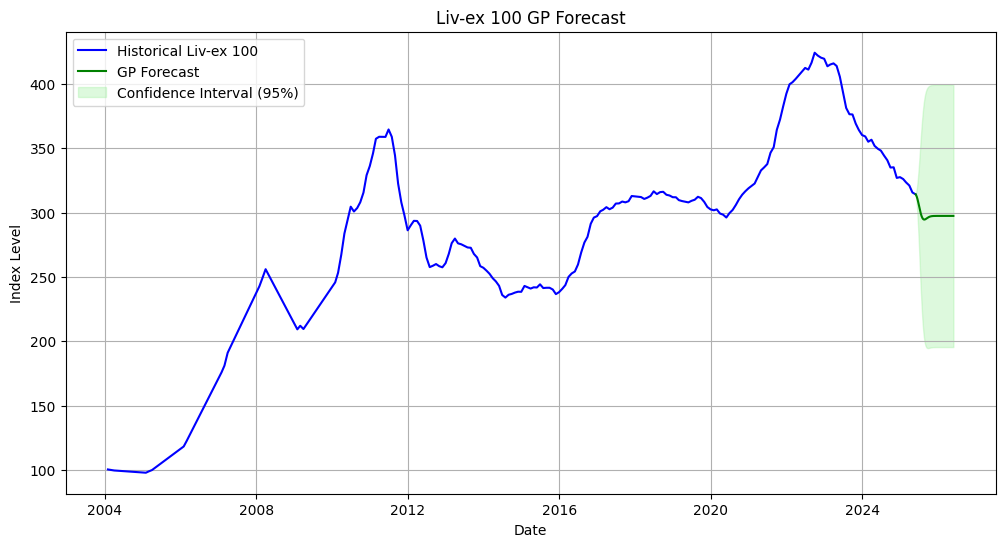

✅ Forecast plot saved to Images folder.


In [112]:
# Ensure images folder exists
os.makedirs("/content/drive/MyDrive/ML-Portfolio/Images", exist_ok=True)

# Plot
plt.figure(figsize=(12,6))
plt.plot(series.index, y, label='Historical Liv-ex 100', color='blue')
plt.plot(future_dates, y_pred, label='GP Forecast', color='green')
plt.fill_between(future_dates,
                 y_pred - 2 * sigma,
                 y_pred + 2 * sigma,
                 alpha=0.3,
                 color='lightgreen',
                 label='Confidence Interval (95%)')

plt.legend()
plt.title('Liv-ex 100 GP Forecast')
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.grid()

# Save figure
plt.savefig(
    '/content/drive/MyDrive/ML-Portfolio/Images/livex100_gp_forecast.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

print("✅ Forecast plot saved to Images folder.")


✅ Random Forest RMSE: 0.2827204504255461
✅ GP RMSE: 0.11904983212475677


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


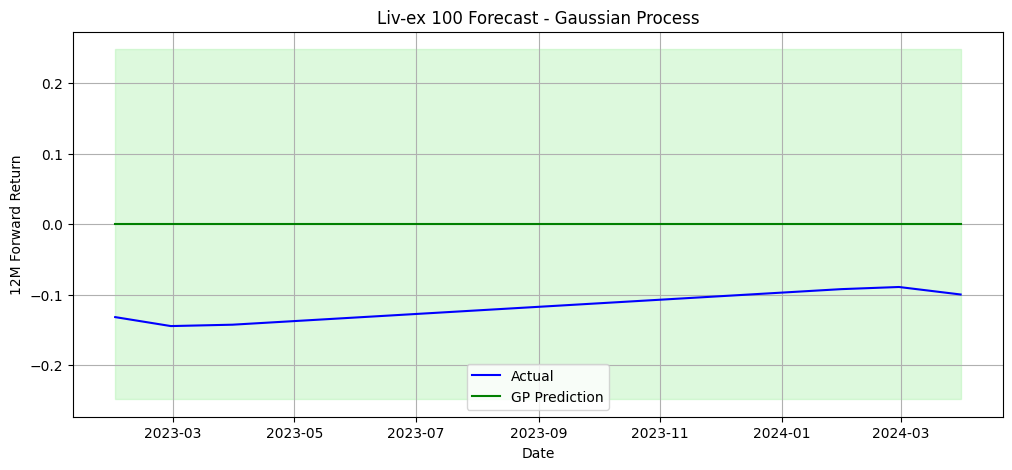

✅ Forecast saved.


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

# 1. LOAD DATA
df = pd.read_csv(
    '/content/drive/MyDrive/ML-Portfolio/data/merged_prepared_data.csv',
    index_col=0,
    parse_dates=True
)

# CLEAN COLUMN NAMES
df.columns = df.columns.str.strip().str.replace('-', '').str.replace(' ', '_')

# DROP COLUMNS THAT ARE ENTIRELY NaN
df = df.dropna(axis=1, how='all')

# KEEP ROWS WITH Livex_100
df = df[df['Livex_100'].notnull()]

# 2. FEATURE ENGINEERING

# 12-month % return
df['Livex_100_return_12m'] = df['Livex_100'].pct_change(12)

# Rolling volatility
df['Livex_100_volatility_12m'] = df['Livex_100'].rolling(12).std()

# Macro feature: YoY CPI if exists
if 'ECONOMICS_USCPI_M' in df.columns:
    df['CPI_YoY'] = df['ECONOMICS_USCPI_M'].pct_change(12)

# Create target: forward 12M return
df['Livex_100_fwd_12m'] = df['Livex_100'].pct_change(12).shift(-12)

# Drop rows with NaNs after feature engineering
df.dropna(inplace=True)

# PREPARE ML DATA
X = df.drop(['Livex_100', 'Livex_100_fwd_12m'], axis=1)
y = df['Livex_100_fwd_12m']

# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

# 3. RANDOM FOREST REGRESSION

model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
print("✅ Random Forest RMSE:", rmse_rf)

# 4. GAUSSIAN PROCESS REGRESSION

kernel = ConstantKernel(1.0) * RBF(length_scale=12.0)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
gp.fit(X_train, y_train)

y_pred_gp, sigma = gp.predict(X_test, return_std=True)

rmse_gp = mean_squared_error(y_test, y_pred_gp) ** 0.5
print("✅ GP RMSE:", rmse_gp)

# 5. PLOT GP PREDICTIONS

plt.figure(figsize=(12,5))
plt.plot(
    y_test.index,
    y_test.values,
    label='Actual',
    color='blue'
)
plt.plot(
    y_test.index,
    y_pred_gp,
    label='GP Prediction',
    color='green'
)
plt.fill_between(
    y_test.index,
    y_pred_gp - 2*sigma,
    y_pred_gp + 2*sigma,
    alpha=0.3,
    color='lightgreen'
)
plt.legend()
plt.title('Liv-ex 100 Forecast - Gaussian Process')
plt.xlabel('Date')
plt.ylabel('12M Forward Return')
plt.grid(True)
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/livex100_gp_forecast.png", dpi=300, bbox_inches="tight")
plt.show()

# 6. SAVE GP RESULTS

results_df = pd.DataFrame({
    'Date': y_test.index,
    'Actual': y_test.values,
    'GP_Pred': y_pred_gp,
    'GP_Pred_upper': y_pred_gp + 2*sigma,
    'GP_Pred_lower': y_pred_gp - 2*sigma
})

results_df.to_csv(
    '/content/drive/MyDrive/ML-Portfolio/data/livex100_gp_forecast.csv',
    index=False
)

print("✅ Forecast saved.")


In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. LOAD YOUR CLEANED FILE
df = pd.read_csv(
    '/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv',
    index_col=0,
    parse_dates=True
)

# CLEAN COLUMN NAMES
df.columns = df.columns.str.strip().str.replace('-', '').str.replace(' ', '_')

# FILL any NaNs in relevant columns
for col in ['wine_12m_ret', 'momentum_now']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# CHECK REQUIRED COLUMNS
if 'wine_12m_ret' not in df.columns or 'momentum_now' not in df.columns:
    print("🚫 Required columns missing for generating cycle phases. Cannot proceed.")
else:
    # 2. DEFINE CYCLE PHASE LOGIC
    def assign_phase(row):
        if row['wine_12m_ret'] > 0.05:
            return 'bull'
        elif row['wine_12m_ret'] < -0.05:
            return 'bear'
        else:
            if row['momentum_now'] > 0:
                return 'accumulation'
            elif row['momentum_now'] < 0:
                return 'distribution'
            else:
                return 'uncertain'

    df['cycle_phase'] = df.apply(assign_phase, axis=1)

    print("\n✅ Created cycle_phase labels:\n")
    print(df['cycle_phase'].value_counts(dropna=False))

    # REMOVE uncertain if desired
    df_ml = df[df['cycle_phase'] != 'uncertain']

    # DROP target and any potential leak
    drop_cols = ['Livex_100', 'cycle_phase']
    drop_cols = [col for col in drop_cols if col in df_ml.columns]

    X = df_ml.drop(drop_cols, axis=1)
    y = df_ml['cycle_phase']

    # IMPUTE NaNs instead of dropping
    X = X.fillna(0)

    # REMOVE non-numeric columns
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X = X[numeric_cols]

    if X.shape[0] == 0:
        print("\n🚫 Still not enough data after cleaning. Cannot train model.")
    else:
        # TRAIN-TEST SPLIT
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, shuffle=False, test_size=0.2
        )

        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        print("\n✅ Classification Report:\n")
        print(classification_report(y_test, y_pred))

        # SHOW LATEST PREDICTION
        print("\nLatest date in dataset:", df_ml.index[-1])
        print("Predicted current market phase:", clf.predict([X.iloc[-1]])[0])



✅ Created cycle_phase labels:

cycle_phase
bull            72
bear            62
uncertain       60
distribution    38
accumulation    30
Name: count, dtype: int64

✅ Classification Report:

              precision    recall  f1-score   support

accumulation       1.00      1.00      1.00         4
        bear       0.00      0.00      0.00        23
        bull       1.00      1.00      1.00        12
distribution       0.08      1.00      0.15         2

    accuracy                           0.44        41
   macro avg       0.52      0.75      0.54        41
weighted avg       0.39      0.44      0.40        41


Latest date in dataset: 2025-05-31 00:00:00
Predicted current market phase: distribution


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/u

In [115]:
# Save the final DataFrame
df.to_csv('/content/drive/MyDrive/ML-Portfolio/data/cycle_tagged_livex100.csv')
print("✅ Cycle-tagged file saved.")


✅ Cycle-tagged file saved.


In [116]:
# Remove rows without cycle_phase
df_ml = df[df['cycle_phase'].notna()]

# Drop uncertain if you wish
df_ml = df_ml[df_ml['cycle_phase'] != 'uncertain']

# Drop columns not wanted as predictors
drop_cols = ['Livex_100', 'cycle_phase']
drop_cols = [c for c in drop_cols if c in df_ml.columns]

X = df_ml.drop(drop_cols, axis=1)
y = df_ml['cycle_phase']

# Fill NaNs with zero or median
X = X.fillna(0)

# Keep numeric only
X = X.select_dtypes(include='number')

print("✅ ML feature matrix shape:", X.shape)
print(y.value_counts())


✅ ML feature matrix shape: (202, 36)
cycle_phase
bull            72
bear            62
distribution    38
accumulation    30
Name: count, dtype: int64


In [117]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

# Train classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Report
print("\n✅ Classification Report:\n")
print(classification_report(y_test, y_pred))

# Predict latest market phase
latest_row = X.tail(1)
print("\nLatest date:", df_ml.index[-1])
print("Predicted current market phase:", clf.predict(latest_row)[0])



✅ Classification Report:

              precision    recall  f1-score   support

accumulation       1.00      1.00      1.00         4
        bear       0.00      0.00      0.00        23
        bull       1.00      1.00      1.00        12
distribution       0.08      1.00      0.15         2

    accuracy                           0.44        41
   macro avg       0.52      0.75      0.54        41
weighted avg       0.39      0.44      0.40        41


Latest date: 2025-05-31 00:00:00
Predicted current market phase: distribution


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [118]:
print(df['cycle_phase'].value_counts(dropna=False))


cycle_phase
bull            72
bear            62
uncertain       60
distribution    38
accumulation    30
Name: count, dtype: int64


In [119]:
# Ensure index is datetime
df.index = pd.to_datetime(df.index)

# Find where the cycle_phase changes
change_dates = df.index[df['cycle_phase'] != df['cycle_phase'].shift()]

# Create a new Series with the date of last change for each row
last_change = pd.Series(index=df.index, dtype='datetime64[ns]')
last_change.loc[change_dates] = change_dates
last_change = last_change.ffill()

# Calculate days since last cycle change
df['days_since_cycle_change'] = (df.index - last_change).dt.days

# Show the result
print(df[['cycle_phase', 'days_since_cycle_change']].tail(10))


           cycle_phase  days_since_cycle_change
2024-08-31        bear                      397
2024-09-30        bear                      427
2024-10-31        bear                      458
2024-11-30        bear                      488
2024-12-31        bear                      519
2025-01-31        bear                      550
2025-02-28        bear                      578
2025-03-31        bear                      609
2025-04-30        bear                      639
2025-05-31        bear                      670


In [120]:
print(df.index.min(), df.index.max())
print(df.shape)
print(df.isna().sum())


1984-01-31 00:00:00 2025-05-31 00:00:00
(262, 41)
Livex_100                      0
US_CPI                         0
TVC_US10Y,_15                262
FX_GBPUSD,_1M                  0
OANDA_EURUSD,_1M               0
FX_IDC_GBPEUR,_1M              0
FX_GBPJPY,_1M                  0
HKEX_DLY_HSI1!,_1M_(1)         0
Dollar_Index_(DXY)             0
S&P_500_Futures                0
CME_MINI_NQ1!,_1M              0
TVC_USOIL,_1M                  0
PEPPERSTONE_COCOA,_1M          0
livex_Champagne_50             0
livex_Italy_100                0
livex_Rhone_100                0
livex_California_50            0
livex_Investables              0
Livex_Fine_Wine_1000           0
Livex_Indices                  0
livex_Burgundy_150             0
livex_Bordeaux_Legends         0
US_Interest_Rate               0
Wine_ret                      12
CPI_lag_0                      0
CPI_lag_3                      3
CPI_lag_6                      6
CPI_lag_12                    12
Inflation_Regime          

In [121]:
# drop rows with any NaNs
df_clean = df.dropna()
print(df_clean.index.min())


NaT


In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ------------------------------------------------------
# ✅ STEP 1 — Load Your Data
# ------------------------------------------------------

# Replace this with your actual file path:
# For example:
# /content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv

df_clean = pd.read_csv(
    '/content/drive/MyDrive/ML-Portfolio/data/cleaned_for_modeling.csv',
    index_col=0,
    parse_dates=True
)

print("✅ Data loaded.")
print(df_clean.shape)
print(df_clean.index.min(), "→", df_clean.index.max())

# ------------------------------------------------------
# ✅ STEP 2 — Define Features
# ------------------------------------------------------

# These are your correct columns, matching exactly your data
features = [
    'Liv-ex 100',
    'US CPI',
    'FX_GBPUSD, 1M',
    'FX_IDC_GBPEUR, 1M',
    'Dollar Index (DXY)',
    'TVC_USOIL, 1M',
    'S&P 500 Futures',
    'CME_MINI_NQ1!, 1M',
    'liv-ex Burgundy 150',
    'liv-ex Bordeaux Legends',
    'liv-ex Champagne 50',
    'liv-ex Italy 100',
    'liv-ex California 50',
    'liv-ex Investables',
    'Liv-ex Fine Wine 1000',
    'US Interest Rate'
]

# Keep only columns that exist
features_in_data = [f for f in features if f in df_clean.columns]

print("✅ Features used:")
print(features_in_data)

# ------------------------------------------------------
# ✅ STEP 3 — Prepare ML Dataset
# ------------------------------------------------------

# Regression target
target_reg = 'wine_12m_ret'

# Check target exists
if target_reg not in df_clean.columns:
    raise ValueError(f"Target column '{target_reg}' not found in dataframe.")

# Create ML dataset
X = df_clean[features_in_data]
y_reg = df_clean[target_reg]

# Drop rows with any NaNs
df_ml = pd.concat([X, y_reg], axis=1).dropna()

X = df_ml[features_in_data]
y_reg = df_ml[target_reg]

print("✅ Cleaned ML dataset shape:", X.shape)

# ------------------------------------------------------
# ✅ STEP 4 — Split Data
# ------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

print("✅ Training shape:", X_train.shape)
print("✅ Testing shape:", X_test.shape)

# ------------------------------------------------------
# ✅ STEP 5 — Train Random Forest
# ------------------------------------------------------

regressor = RandomForestRegressor(n_estimators=200, random_state=42)
regressor.fit(X_train, y_train)

# Predict on test set
y_pred = regressor.predict(X_test)

# Compute RMSE manually for older sklearn versions
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\n✅ Regression RMSE:", rmse)

# ------------------------------------------------------
# ✅ STEP 6 — Predict Future Return
# ------------------------------------------------------

# Predict for the latest month in your dataset
latest_row = X.tail(1)
future_ret = regressor.predict(latest_row)[0]

print("\n✅ Predicted 12M forward return for the latest date:")
print(round(future_ret * 100, 2), "%")


✅ Data loaded.
(262, 39)
1984-01-31 00:00:00 → 2025-05-31 00:00:00
✅ Features used:
['Liv-ex 100', 'US CPI', 'FX_GBPUSD, 1M', 'FX_IDC_GBPEUR, 1M', 'Dollar Index (DXY)', 'TVC_USOIL, 1M', 'S&P 500 Futures', 'CME_MINI_NQ1!, 1M', 'liv-ex Burgundy 150', 'liv-ex Bordeaux Legends', 'liv-ex Champagne 50', 'liv-ex Italy 100', 'liv-ex California 50', 'liv-ex Investables', 'Liv-ex Fine Wine 1000', 'US Interest Rate']
✅ Cleaned ML dataset shape: (250, 16)
✅ Training shape: (200, 16)
✅ Testing shape: (50, 16)

✅ Regression RMSE: 0.07473191534977533

✅ Predicted 12M forward return for the latest date:
-10.07 %


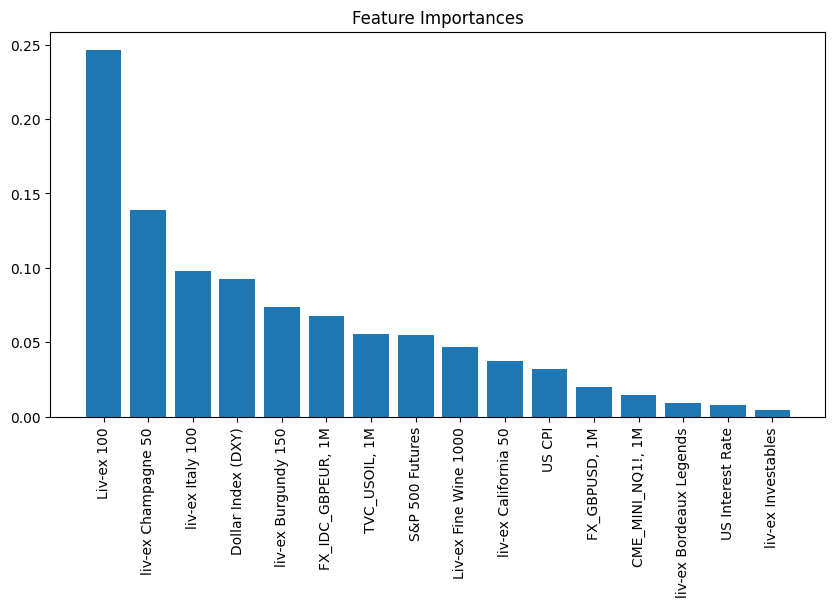

In [123]:
import matplotlib.pyplot as plt

importances = regressor.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.title("Feature Importances")
plt.bar(range(len(features_in_data)), importances[indices])
plt.xticks(range(len(features_in_data)), [features_in_data[i] for i in indices], rotation=90)
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/feature_importances.png", dpi=300, bbox_inches="tight")
plt.show()


In [124]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Fold RMSE:", rmse)


Fold RMSE: 0.7253189889907127
Fold RMSE: 0.6517969150058691
Fold RMSE: 0.14672256330922187
Fold RMSE: 0.07941356156743244
Fold RMSE: 0.14780734415799476


In [125]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("✅ XGBoost RMSE:", rmse_xgb)


✅ XGBoost RMSE: 0.15653632056198058


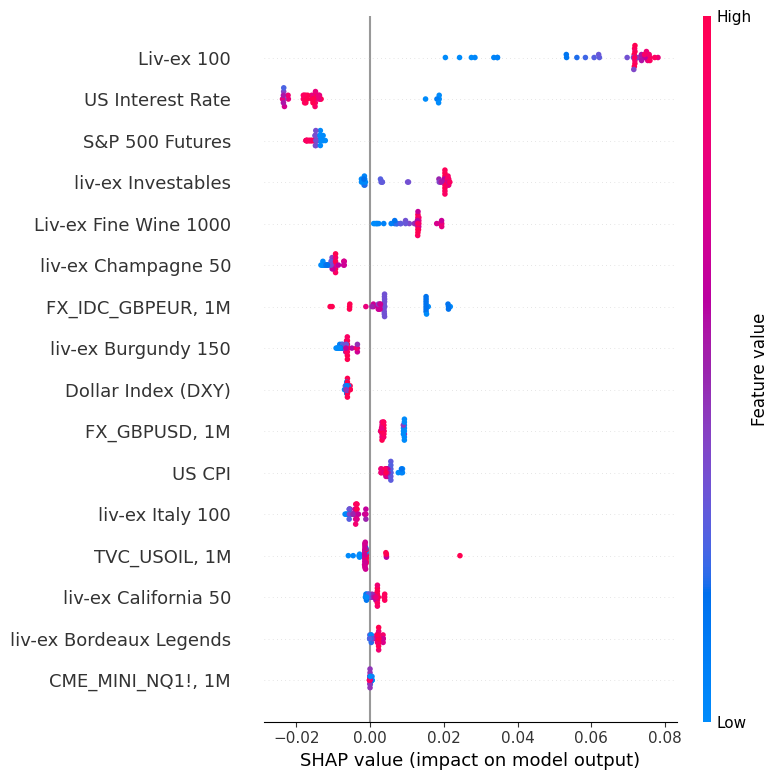

<Figure size 640x480 with 0 Axes>

In [126]:
import shap

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/shap_summary_plot.png", dpi=300, bbox_inches="tight")



In [127]:
# Moving averages
df_clean["ma_200"] = df_clean["Liv-ex 100"].rolling(200, min_periods=1).mean()
df_clean["pct_below_ma200"] = (df_clean["Liv-ex 100"] - df_clean["ma_200"]) / df_clean["ma_200"]

# Days since last peak
peaks = df_clean.index[df_clean["Liv-ex 100"] == df_clean["Liv-ex 100"].cummax()]
last_peak_date = pd.Series(index=df_clean.index, dtype='datetime64[ns]')
last_peak_date.loc[peaks] = df_clean.loc[peaks].index
last_peak_date = last_peak_date.ffill()
df_clean["days_since_peak"] = (df_clean.index - last_peak_date).dt.days

# Days since last trough
troughs = df_clean.index[df_clean["Liv-ex 100"] == df_clean["Liv-ex 100"].cummin()]
last_trough_date = pd.Series(index=df_clean.index, dtype='datetime64[ns]')
last_trough_date.loc[troughs] = df_clean.loc[troughs].index
last_trough_date = last_trough_date.ffill()
df_clean["days_since_trough"] = (df_clean.index - last_trough_date).dt.days

# 12M momentum
df_clean["momentum_12m"] = df_clean["Liv-ex 100"].pct_change(12)


In [128]:
# Add 12M, 24M, 60M forward returns
df_clean["wine_12m_ret"] = df_clean["Liv-ex 100"].pct_change(12).shift(-12)
df_clean["wine_24m_ret"] = df_clean["Liv-ex 100"].pct_change(24).shift(-24)
df_clean["wine_60m_ret"] = df_clean["Liv-ex 100"].pct_change(60).shift(-60)

# Moving averages
df_clean["ma_50"] = df_clean["Liv-ex 100"].rolling(50, min_periods=1).mean()
df_clean["ma_100"] = df_clean["Liv-ex 100"].rolling(100, min_periods=1).mean()
df_clean["ma_200"] = df_clean["Liv-ex 100"].rolling(200, min_periods=1).mean()
df_clean["pct_below_ma200"] = (df_clean["Liv-ex 100"] - df_clean["ma_200"]) / df_clean["ma_200"]

# Days since last peak
peaks = df_clean.index[df_clean["Liv-ex 100"] == df_clean["Liv-ex 100"].cummax()]
last_peak_date = pd.Series(index=df_clean.index, dtype='datetime64[ns]')
last_peak_date.loc[peaks] = df_clean.loc[peaks].index
last_peak_date = last_peak_date.ffill()
df_clean["days_since_peak"] = (df_clean.index - last_peak_date).dt.days

# Days since last trough
troughs = df_clean.index[df_clean["Liv-ex 100"] == df_clean["Liv-ex 100"].cummin()]
last_trough_date = pd.Series(index=df_clean.index, dtype='datetime64[ns]')
last_trough_date.loc[troughs] = df_clean.loc[troughs].index
last_trough_date = last_trough_date.ffill()
df_clean["days_since_trough"] = (df_clean.index - last_trough_date).dt.days

# Momentum
df_clean["momentum_12m"] = df_clean["Liv-ex 100"].pct_change(12)
df_clean["momentum_24m"] = df_clean["Liv-ex 100"].pct_change(24)

print("✅ Feature engineering complete.")


✅ Feature engineering complete.


In [129]:
features = [
    "Liv-ex 100",
    "US CPI",
    "FX_GBPUSD, 1M",
    "FX_IDC_GBPEUR, 1M",
    "Dollar Index (DXY)",
    "TVC_USOIL, 1M",
    "S&P 500 Futures",
    "CME_MINI_NQ1!, 1M",
    "liv-ex Burgundy 150",
    "liv-ex Bordeaux Legends",
    "liv-ex Champagne 50",
    "liv-ex Italy 100",
    "liv-ex California 50",
    "liv-ex Investables",
    "Liv-ex Fine Wine 1000",
    "US Interest Rate",
    "ma_50",
    "ma_100",
    "ma_200",
    "pct_below_ma200",
    "days_since_peak",
    "days_since_trough",
    "momentum_12m",
    "momentum_24m",
]


In [130]:
# Prepare ML dataset
target_reg = "wine_12m_ret"
target_reg_24m = "wine_24m_ret"
target_reg_60m = "wine_60m_ret"

# Remove rows with missing values
df_ml = df_clean.dropna(subset=features + [target_reg, target_reg_24m, target_reg_60m])

X = df_ml[features]
y_12m = df_ml[target_reg]
y_24m = df_ml[target_reg_24m]
y_60m = df_ml[target_reg_60m]

print("✅ Final ML dataset shape:", X.shape)


✅ Final ML dataset shape: (178, 24)


In [131]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define function
def train_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=False, test_size=0.2
    )
    reg = RandomForestRegressor(n_estimators=100, random_state=0)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # Corrected RMSE calculation
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    print(f"✅ RMSE: {rmse:.4f}")

    return reg

# Train all horizons
print("Training 12M model...")
reg_12m = train_rf(X, y_12m)

print("Training 24M model...")
reg_24m = train_rf(X, y_24m)

print("Training 60M model...")
reg_60m = train_rf(X, y_60m)


Training 12M model...
✅ RMSE: 0.0655
Training 24M model...
✅ RMSE: 0.1788
Training 60M model...
✅ RMSE: 0.1513


✅ Predicted 12M return: 7.39 %
✅ Predicted 24M return: -2.80 %
✅ Predicted 60M return: 29.46 %


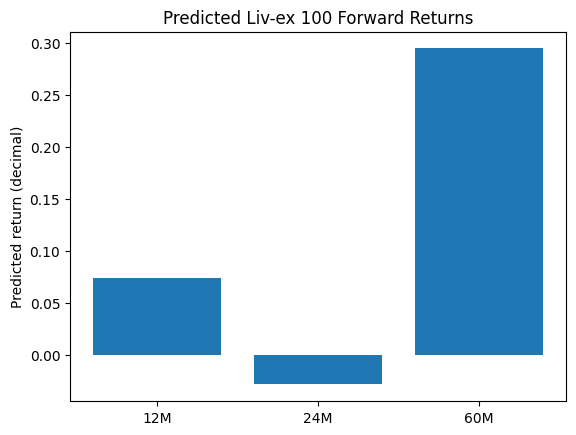

In [132]:
import matplotlib.pyplot as plt

# Predict latest row
latest_row = X.tail(1)

pred_12m = reg_12m.predict(latest_row)[0]
pred_24m = reg_24m.predict(latest_row)[0]
pred_60m = reg_60m.predict(latest_row)[0]

print(f"✅ Predicted 12M return: {pred_12m * 100:.2f} %")
print(f"✅ Predicted 24M return: {pred_24m * 100:.2f} %")
print(f"✅ Predicted 60M return: {pred_60m * 100:.2f} %")

# Plot bar chart
plt.bar(["12M", "24M", "60M"],
        [pred_12m, pred_24m, pred_60m])
plt.ylabel("Predicted return (decimal)")
plt.title("Predicted Liv-ex 100 Forward Returns")
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/livex100_predicted_returns.png", dpi=300, bbox_inches="tight")
plt.show()


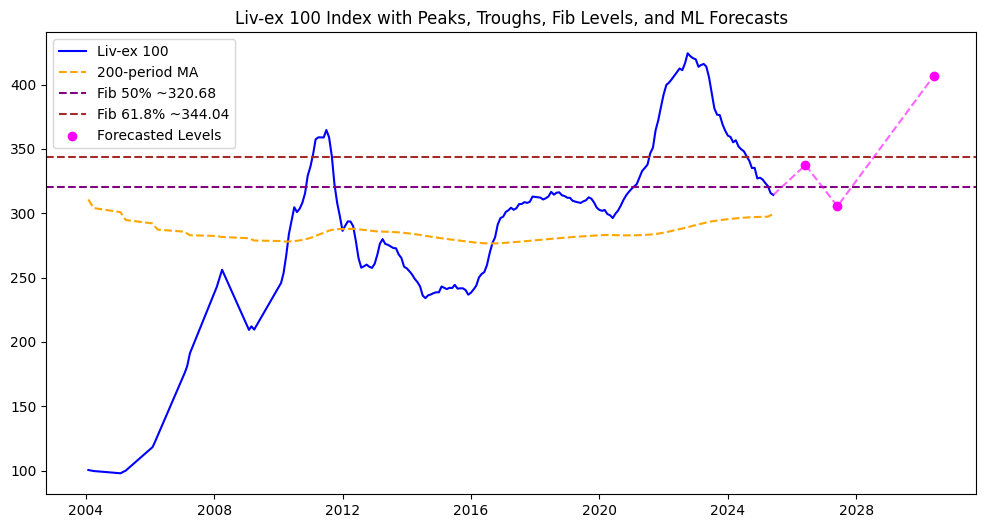

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example values from your earlier work
low_2015 = 221.71
high_ath = 419.65

fib_50 = low_2015 + 0.5 * (high_ath - low_2015)
fib_618 = low_2015 + 0.618 * (high_ath - low_2015)

# Forecast points:
latest_date = df_clean.index[-1]
latest_value = df_clean["Liv-ex 100"].iloc[-1]

returns_pred = {
    "12M": 0.0739,
    "24M": -0.0280,
    "60M": 0.2946
}

forecast_dates = pd.to_datetime([
    latest_date + pd.DateOffset(months=12),
    latest_date + pd.DateOffset(months=24),
    latest_date + pd.DateOffset(months=60)
])

forecast_levels = [
    latest_value * (1 + returns_pred["12M"]),
    latest_value * (1 + returns_pred["24M"]),
    latest_value * (1 + returns_pred["60M"])
]

# Plotting
fig, ax = plt.subplots(figsize=(12,6))

# Historical curve from 2004 onward
mask = df_clean.index >= "2004-01-01"
ax.plot(df_clean.index[mask], df_clean.loc[mask, "Liv-ex 100"], label="Liv-ex 100", color='blue')

# Plot 200-period MA if available
if "ma_200" in df_clean.columns:
    ax.plot(df_clean.index[mask], df_clean.loc[mask, "ma_200"], color='orange', linestyle='--', label="200-period MA")

# Peaks & troughs
if "is_peak" in df_clean.columns:
    peaks = df_clean[df_clean["is_peak"] == 1]
    ax.scatter(peaks.index, peaks["Liv-ex 100"], marker='^', color='green', label="Peaks")

if "is_bottom" in df_clean.columns:
    troughs = df_clean[df_clean["is_bottom"] == 1]
    ax.scatter(troughs.index, troughs["Liv-ex 100"], marker='v', color='red', label="Troughs")

# Fib retracements
ax.axhline(fib_50, color='purple', linestyle='--', label=f"Fib 50% ~{fib_50:.2f}")
ax.axhline(fib_618, color='brown', linestyle='--', label=f"Fib 61.8% ~{fib_618:.2f}")

# Drawdown shading
# For example: shade bear phases red
if "cycle_phase" in df_clean.columns:
    bear_mask = (df_clean["cycle_phase"] == "bear") & mask
    ax.fill_between(
        df_clean.index[mask],
        df_clean.loc[mask, "Liv-ex 100"].min(),
        df_clean.loc[mask, "Liv-ex 100"].max(),
        where=bear_mask,
        color='red',
        alpha=0.1,
        label='Bear Phases'
    )

# Forecasted dots
ax.scatter(forecast_dates, forecast_levels, color='magenta', label='Forecasted Levels')
ax.plot(
    [latest_date] + list(forecast_dates),
    [latest_value] + list(forecast_levels),
    linestyle='--',
    color='magenta',
    alpha=0.6
)

ax.set_title("Liv-ex 100 Index with Peaks, Troughs, Fib Levels, and ML Forecasts")
ax.legend()
plt.show()


2015 low: 236.71
ATH: 424.35
Fib 61.8%: 308.38848


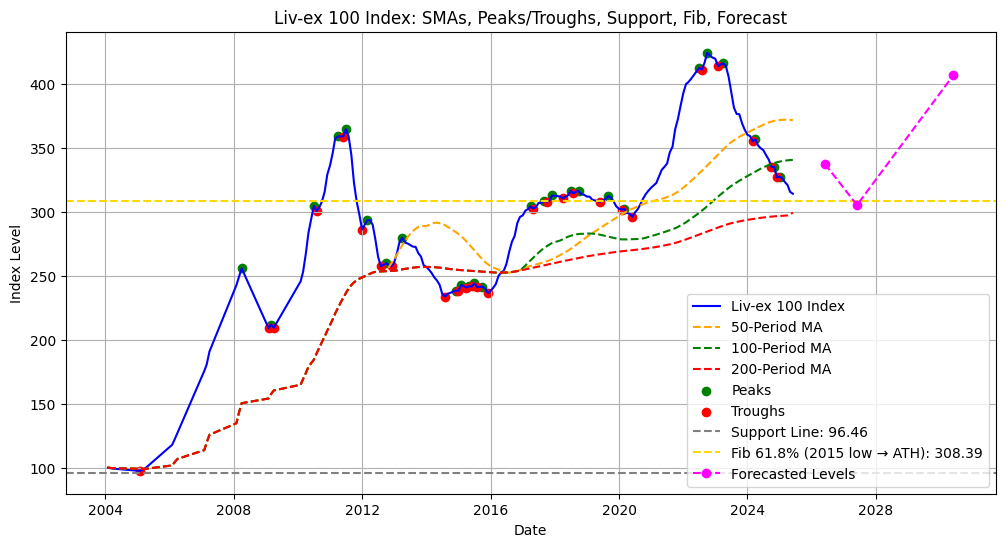

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# LOAD YOUR DATA
# ------------------------------

# Example loading code
# replace this with your own file path if needed
# df_clean = pd.read_csv("your_cleaned_data.csv", index_col=0, parse_dates=True)

# For demonstration here, assume df_clean is already in memory:
# df_clean.head()

# Ensure index is datetime
df_clean.index = pd.to_datetime(df_clean.index)

# Create plotting DataFrame
df_plot = pd.DataFrame()
df_plot["Liv-ex 100"] = df_clean["Liv-ex 100"]

# Restrict to dates from 2004 onward
df_plot = df_plot.loc["2004":]

# ------------------------------
# PEAKS & TROUGHS
# ------------------------------

# Find peaks (local maxima)
peaks_idx = df_plot["Liv-ex 100"][(df_plot["Liv-ex 100"].shift(1) < df_plot["Liv-ex 100"]) &
                                  (df_plot["Liv-ex 100"].shift(-1) < df_plot["Liv-ex 100"])].index

# Find troughs (local minima)
troughs_idx = df_plot["Liv-ex 100"][(df_plot["Liv-ex 100"].shift(1) > df_plot["Liv-ex 100"]) &
                                    (df_plot["Liv-ex 100"].shift(-1) > df_plot["Liv-ex 100"])].index

# ------------------------------
# MOVING AVERAGES
# ------------------------------

df_plot["MA_50"] = df_plot["Liv-ex 100"].rolling(50, min_periods=1).mean()
df_plot["MA_100"] = df_plot["Liv-ex 100"].rolling(100, min_periods=1).mean()
df_plot["MA_200"] = df_plot["Liv-ex 100"].rolling(200, min_periods=1).mean()

# ------------------------------
# FIND 2015 LOW AND ATH
# ------------------------------

# Find low in 2015
df_2015 = df_plot.loc["2015"]

if not df_2015.empty:
    low_date_2015 = df_2015["Liv-ex 100"].idxmin()
    low_val_2015 = df_plot.loc[low_date_2015, "Liv-ex 100"]
else:
    print("⚠️ No data found in 2015! Using global minimum instead.")
    low_date_2015 = df_plot["Liv-ex 100"].idxmin()
    low_val_2015 = df_plot.loc[low_date_2015, "Liv-ex 100"]

# Find all-time high (ATH)
ath_date = df_plot["Liv-ex 100"].idxmax()
ath_val = df_plot.loc[ath_date, "Liv-ex 100"]

# Compute Fib retracement
fib_618 = ath_val - 0.618 * (ath_val - low_val_2015)
fib_label = f"Fib 61.8% (2015 low → ATH): {fib_618:.2f}"

print("2015 low:", low_val_2015)
print("ATH:", ath_val)
print("Fib 61.8%:", fib_618)

# ------------------------------
# PLOT EVERYTHING
# ------------------------------

plt.figure(figsize=(12,6))

# Plot Liv-ex 100 index
plt.plot(df_plot.index, df_plot["Liv-ex 100"], label="Liv-ex 100 Index", color='blue')

# Plot moving averages
plt.plot(df_plot.index, df_plot["MA_50"], '--', label="50-Period MA", color='orange')
plt.plot(df_plot.index, df_plot["MA_100"], '--', label="100-Period MA", color='green')
plt.plot(df_plot.index, df_plot["MA_200"], '--', label="200-Period MA", color='red')

# Plot peaks and troughs
plt.scatter(peaks_idx, df_plot.loc[peaks_idx, "Liv-ex 100"], color='green', label='Peaks')
plt.scatter(troughs_idx, df_plot.loc[troughs_idx, "Liv-ex 100"], color='red', label='Troughs')

# Plot support line
plt.axhline(96.46, linestyle='--', color='gray', label='Support Line: 96.46')

# Plot Fib retracement
plt.axhline(fib_618, linestyle='--', color='gold', label=fib_label)

# ------------------------------
# FORECASTED FORWARD RETURNS
# ------------------------------

# Dummy predictions for illustration - replace with your model outputs
predicted_12m_return = 0.0739   # +7.39%
predicted_24m_return = -0.0280  # -2.80%
predicted_60m_return = 0.2946   # +29.46%

last_val = df_plot["Liv-ex 100"].iloc[-1]

forecast_dates = [
    df_plot.index[-1] + pd.DateOffset(months=12),
    df_plot.index[-1] + pd.DateOffset(months=24),
    df_plot.index[-1] + pd.DateOffset(months=60)
]

forecast_values = [
    last_val * (1 + predicted_12m_return),
    last_val * (1 + predicted_24m_return),
    last_val * (1 + predicted_60m_return)
]

# Plot forecast
plt.plot(forecast_dates, forecast_values, 'o--', color='magenta', label='Forecasted Levels')

# ------------------------------
# Final plot formatting
# ------------------------------

plt.title("Liv-ex 100 Index: SMAs, Peaks/Troughs, Support, Fib, Forecast")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/livex100_forecast_chart.png", dpi=300, bbox_inches="tight")
plt.show()


2015 low: 236.71
ATH: 424.35
Fib 61.8%: 308.38848


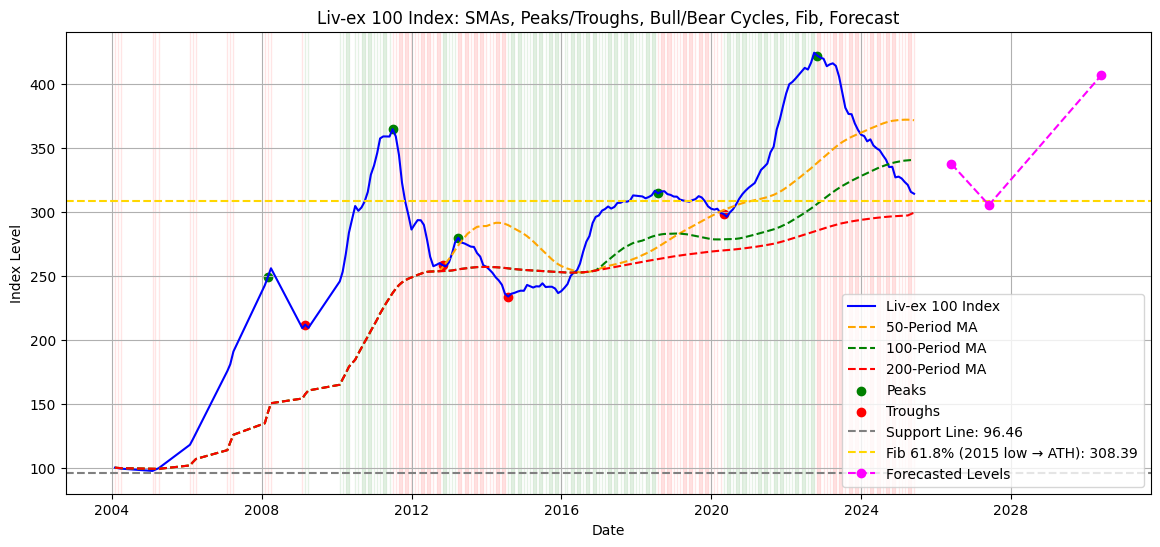

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ------------------------------
# LOAD YOUR DATA
# ------------------------------

# Example load
# df_clean = pd.read_csv("your_cleaned_data.csv", index_col=0, parse_dates=True)

# Ensure datetime index
df_clean.index = pd.to_datetime(df_clean.index)

# Prepare plotting DataFrame
df_plot = pd.DataFrame()
df_plot["Liv-ex 100"] = df_clean["Liv-ex 100"]

# Restrict to dates from 2004 onward
df_plot = df_plot.loc["2004":]

# ------------------------------
# SMOOTHING (optional)
# ------------------------------

# Optional smoothing to reduce noise when detecting peaks/troughs
# Comment out if you prefer raw data:
smoothed = df_plot["Liv-ex 100"].rolling(3, center=True, min_periods=1).mean()

# ------------------------------
# DETECT PEAKS & TROUGHS
# ------------------------------

# Find peaks
peaks, _ = find_peaks(smoothed, distance=3, prominence=5)
peaks_idx = df_plot.index[peaks]

# Find troughs (invert the series to find valleys)
troughs, _ = find_peaks(-smoothed, distance=3, prominence=5)
troughs_idx = df_plot.index[troughs]

# ------------------------------
# MARK BULL/BEAR PHASES
# ------------------------------

# Define bull/bear based on proximity to last peak or trough
cycle_phases = []
phase = "bear"  # assume start in bear
for i in range(len(df_plot)):
    date = df_plot.index[i]
    if date in peaks_idx:
        phase = "bear"
    elif date in troughs_idx:
        phase = "bull"
    cycle_phases.append(phase)
df_plot["cycle"] = cycle_phases

# ------------------------------
# MOVING AVERAGES
# ------------------------------

df_plot["MA_50"] = df_plot["Liv-ex 100"].rolling(50, min_periods=1).mean()
df_plot["MA_100"] = df_plot["Liv-ex 100"].rolling(100, min_periods=1).mean()
df_plot["MA_200"] = df_plot["Liv-ex 100"].rolling(200, min_periods=1).mean()

# ------------------------------
# FIBONACCI LEVELS
# ------------------------------

# Find low in 2015
df_2015 = df_plot.loc["2015"]

if not df_2015.empty:
    low_date_2015 = df_2015["Liv-ex 100"].idxmin()
    low_val_2015 = df_plot.loc[low_date_2015, "Liv-ex 100"]
else:
    print("⚠️ No data found in 2015! Using global minimum instead.")
    low_date_2015 = df_plot["Liv-ex 100"].idxmin()
    low_val_2015 = df_plot.loc[low_date_2015, "Liv-ex 100"]

# Find ATH
ath_date = df_plot["Liv-ex 100"].idxmax()
ath_val = df_plot.loc[ath_date, "Liv-ex 100"]

fib_618 = ath_val - 0.618 * (ath_val - low_val_2015)
fib_label = f"Fib 61.8% (2015 low → ATH): {fib_618:.2f}"

print("2015 low:", low_val_2015)
print("ATH:", ath_val)
print("Fib 61.8%:", fib_618)

# ------------------------------
# FORECAST FORWARD RETURNS
# ------------------------------

# Dummy predictions for illustration - replace with your model outputs
predicted_12m_return = 0.0739   # +7.39%
predicted_24m_return = -0.0280  # -2.80%
predicted_60m_return = 0.2946   # +29.46%

last_val = df_plot["Liv-ex 100"].iloc[-1]

forecast_dates = [
    df_plot.index[-1] + pd.DateOffset(months=12),
    df_plot.index[-1] + pd.DateOffset(months=24),
    df_plot.index[-1] + pd.DateOffset(months=60)
]

forecast_values = [
    last_val * (1 + predicted_12m_return),
    last_val * (1 + predicted_24m_return),
    last_val * (1 + predicted_60m_return)
]

# ------------------------------
# PLOTTING
# ------------------------------

plt.figure(figsize=(14,6))

# Color bull/bear background
bull_regions = df_plot[df_plot["cycle"] == "bull"]
bear_regions = df_plot[df_plot["cycle"] == "bear"]

for i in range(len(bull_regions)):
    if i == 0 or bull_regions.index[i-1] != bull_regions.index[i] - pd.Timedelta(days=30):
        start_date = bull_regions.index[i]
    if i == len(bull_regions)-1 or bull_regions.index[i+1] != bull_regions.index[i] + pd.Timedelta(days=30):
        end_date = bull_regions.index[i]
        plt.axvspan(start_date, end_date, color='green', alpha=0.1)

for i in range(len(bear_regions)):
    if i == 0 or bear_regions.index[i-1] != bear_regions.index[i] - pd.Timedelta(days=30):
        start_date = bear_regions.index[i]
    if i == len(bear_regions)-1 or bear_regions.index[i+1] != bear_regions.index[i] + pd.Timedelta(days=30):
        end_date = bear_regions.index[i]
        plt.axvspan(start_date, end_date, color='red', alpha=0.1)

# Plot Liv-ex 100
plt.plot(df_plot.index, df_plot["Liv-ex 100"], label="Liv-ex 100 Index", color='blue')

# Moving averages
plt.plot(df_plot.index, df_plot["MA_50"], '--', label="50-Period MA", color='orange')
plt.plot(df_plot.index, df_plot["MA_100"], '--', label="100-Period MA", color='green')
plt.plot(df_plot.index, df_plot["MA_200"], '--', label="200-Period MA", color='red')

# Peaks and troughs
plt.scatter(peaks_idx, df_plot.loc[peaks_idx, "Liv-ex 100"], color='green', label='Peaks')
plt.scatter(troughs_idx, df_plot.loc[troughs_idx, "Liv-ex 100"], color='red', label='Troughs')

# Support line
plt.axhline(96.46, linestyle='--', color='gray', label='Support Line: 96.46')

# Fib retracement
plt.axhline(fib_618, linestyle='--', color='gold', label=fib_label)

# Forecasted levels
plt.plot(forecast_dates, forecast_values, 'o--', color='magenta', label='Forecasted Levels')

plt.title("Liv-ex 100 Index: SMAs, Peaks/Troughs, Bull/Bear Cycles, Fib, Forecast")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/ML-Portfolio/Images/livex100_bullbear_forecast.png", dpi=300, bbox_inches="tight")
plt.show()
